In [1]:
import matplotlib.pyplot as plt
from xml.etree import ElementTree
import pandas as pd
import datetime

In [2]:
tree = ElementTree.parse('C:/Users/9/Downloads/экспорт/apple_health_export/экспорт.xml')
root = tree.getroot()
records = root.findall('Record')

In [3]:
records_dict = {'type': [],
                'unit': [],
                'creationDate': [],
                'startDate': [],
                'endDate': [],
                'value': []
               }

In [4]:
for record in records:
    for attribute in records_dict.keys():
        attribute_value = record.get(attribute)
        records_dict[attribute].append(attribute_value)

In [5]:
types_dict = {
    'HKCategoryTypeIdentifierMindfulSession': 'Mindful Session',
    'HKQuantityTypeIdentifierDistanceCycling': 'Cycling Distance',
    'HKQuantityTypeIdentifierDistanceSwimming': 'Swimming Distance',
    'HKQuantityTypeIdentifierDistanceWalkingRunning': 'Walking + Running Distance',
    'HKQuantityTypeIdentifierFlightsClimbed': 'Flights Climbed',
    'HKQuantityTypeIdentifierHeartRate': 'Heart Rate',
    'HKQuantityTypeIdentifierRestingHeartRate': 'Resting Heart Rate',
    'HKQuantityTypeIdentifierStepCount': 'Steps',
    'HKQuantityTypeIdentifierActiveEnergyBurned': 'Active Calories',
    'HKQuantityTypeIdentifierBasalEnergyBurned': 'Resting Calories',
    'HKQuantityTypeIdentifierWalkingHeartRateAverage': 'Walking Heart Rate Average'
}

In [6]:
def td_to_m(td):
    seconds = td.seconds + td.days * 24 * 60 * 60
    return seconds // 60

In [7]:
df = pd.DataFrame(records_dict)
df.columns = ['type', 'unit', 'date', 'start', 'end', 'value']
df = df[df['type'].isin(types_dict.keys())]
df['value'] = df['value'].astype(float)
df['date'] = df['date'].astype('datetime64')
df['date'] = df['date'].dt.date
df['start'] = df['start'].astype('datetime64')
df['end'] = df['end'].astype('datetime64')
df['unit'] = df['unit'].astype(str)

In [8]:
df_1 = df[df['unit'] == 'count/min']
df_1 = df_1.groupby(by=['date', 'type', 'unit'], as_index=False).agg({'start':'min',
                                                                      'end':'max',
                                                                      'value':'mean'})

In [9]:
df_2 = df[df['type'] == 'HKCategoryTypeIdentifierMindfulSession']
df_2['value'] = df_2['end'] - df_2['start']
df_2['value'] = df_2['value'].map(td_to_m)
df_2 = df_2.groupby(by=['date', 'type', 'unit'], as_index=False).agg({'start':'min',
                                                                     'end':'max',
                                                                     'value':'sum'})

<ipython-input-9-9aefcd8c8fa8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['value'] = df_2['end'] - df_2['start']
<ipython-input-9-9aefcd8c8fa8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['value'] = df_2['value'].map(td_to_m)


In [10]:
df_3 = df[(df['unit'] != 'count/min') & (df['type'] != 'HKCategoryTypeIdentifierMindfulSession')]
df_3 = df_3.groupby(by=['date', 'type', 'unit'], as_index=False).agg({'start':'min',
                                                                      'end':'max',
                                                                      'value':'sum'})

In [11]:
df = pd.concat([df_1, df_2, df_3])

In [12]:
df['date'] = df['date'].astype(str)
df['type'] = df['type'].apply(lambda x: types_dict[x])
dates = df['date'].unique()

In [13]:
result = {
    'date': [],
    'Steps': [],
    'Walking + Running Distance': [],
    'Swimming Distance': [],
    'Cycling Distance': [],
    'Resting Calories': [],
    'Active Calories': [],
    'Flights Climbed': [],
    'Heart Rate': [],
    'Resting Heart Rate': [],
    'Walking Heart Rate Average': [],
    'Mindful Session': []
}

In [14]:
for date in dates:
    part = df[df['date'] == date]
    result['date'].append(date)
    for key in result.keys():
        if key == 'date':
            continue
        else:
            field = 'value'
        try:
            result[key].append(part[part['type'] == key][field].values[0])
        except IndexError:
            result[key].append(None)

In [15]:
result_df = pd.DataFrame(result)

In [16]:
result_df = result_df.round(2)

In [17]:
result_df = result_df.sort_values(by='date')

In [18]:
data = result_df

In [19]:
data.head(10)

,date,Steps,Walking + Running Distance,Swimming Distance,Cycling Distance,Resting Calories,Active Calories,Flights Climbed,Heart Rate,Resting Heart Rate,Walking Heart Rate Average,Mindful Session
839,2018-04-21,8607.0,5.72,None,None,NaN,NaN,17.0,NaN,NaN,NaN,NaN
840,2018-04-22,13569.0,8.79,None,None,NaN,NaN,10.0,NaN,NaN,NaN,NaN
841,2018-04-23,13678.0,9.36,None,None,NaN,NaN,48.0,NaN,NaN,NaN,NaN
842,2018-04-24,10244.0,6.56,None,None,NaN,NaN,7.0,NaN,NaN,NaN,NaN
843,2018-04-25,5415.0,3.49,None,None,NaN,NaN,23.0,NaN,NaN,NaN,NaN
844,2018-04-26,10987.0,7.06,None,None,NaN,NaN,1.0,NaN,NaN,NaN,NaN
845,2018-04-27,18742.0,12.20,None,None,NaN,NaN,5.0,NaN,NaN,NaN,NaN
846,2018-04-28,3975.0,2.50,None,None,NaN,NaN,1.0,NaN,NaN,NaN,NaN
847,2018-04-29,5618.0,3.76,None,None,NaN,NaN,1.0,NaN,NaN,NaN,NaN
848,2018-04-30,18485.0,12.09,None,None,NaN,NaN,20.0,NaN,NaN,NaN,NaN


In [20]:
walking = data.drop(['Swimming Distance', 'Cycling Distance', 'Resting Calories', 'Active Calories', 'Flights Climbed', 'Heart Rate', 'Resting Heart Rate', 'Walking Heart Rate Average', 'Mindful Session'], axis =1)

In [21]:
walking.head(10)

,date,Steps,Walking + Running Distance
839,2018-04-21,8607.0,5.72
840,2018-04-22,13569.0,8.79
841,2018-04-23,13678.0,9.36
842,2018-04-24,10244.0,6.56
843,2018-04-25,5415.0,3.49
844,2018-04-26,10987.0,7.06
845,2018-04-27,18742.0,12.20
846,2018-04-28,3975.0,2.50
847,2018-04-29,5618.0,3.76
848,2018-04-30,18485.0,12.09


In [22]:
walking = walking.reset_index(drop=True)

In [23]:
walking = walking.loc[:230]

In [24]:
walking.head()

,date,Steps,Walking + Running Distance
0,2018-04-21,8607.0,5.72
1,2018-04-22,13569.0,8.79
2,2018-04-23,13678.0,9.36
3,2018-04-24,10244.0,6.56
4,2018-04-25,5415.0,3.49


In [25]:
walking.sort_values(['Steps'], ascending=False)

,date,Steps,Walking + Running Distance
189,2018-10-27,84149.0,56.04
201,2018-11-08,75495.0,53.91
203,2018-11-10,60297.0,39.16
168,2018-10-06,55020.0,34.07
195,2018-11-02,53672.0,33.79
...,...,...,...
192,2018-10-30,NaN,NaN
199,2018-11-06,NaN,NaN
200,2018-11-07,NaN,NaN
204,2018-11-11,NaN,NaN


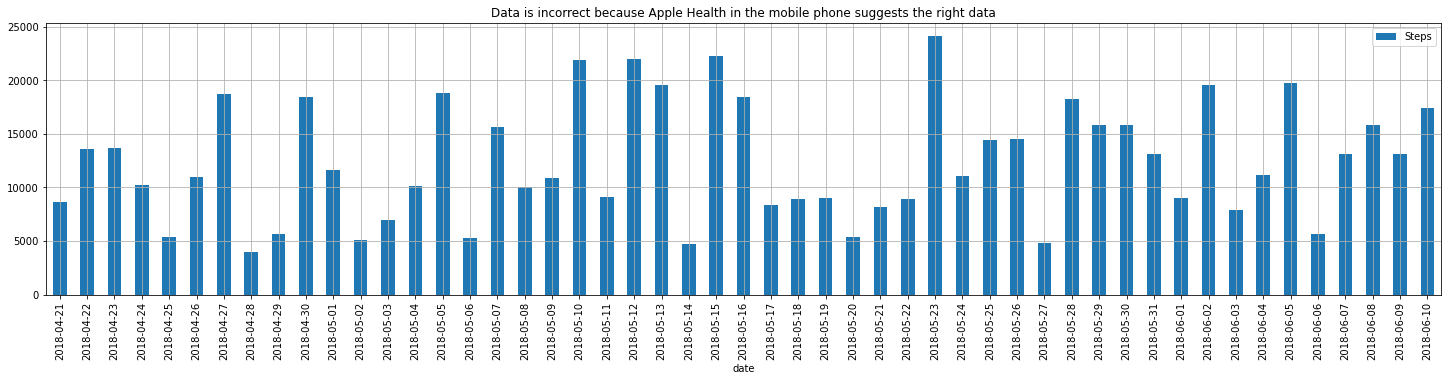

In [26]:
walking.loc[:50].plot(x = 'date', y = 'Steps', 
                      kind='bar', 
                      figsize = (25, 5), 
                      grid = 'bool', 
                      title = 'Data is incorrect because Apple Health in the mobile phone suggests the right data')